In [90]:
# from sklearn.linear_model import LinearRegression
# from sklearn import metrics
import sklearn
import sklearn.pipeline
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from statsmodels.stats import diagnostic
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('dataset/machine.data',
        names=['vendor', 'model', 'MYCT', 'MMIN', 'MMAX',
               'CACH', 'CHMIN', 'CHMAX', 'PRP', 'ERP'])
conv_dict = {
'MYCT': 'machine cycle time in nanoseconds',
'MMIN': 'minimum main memory in kilobytes',
'MMAX': 'maximum main memory in kilobytes',
'CACH': 'cache memory in kilobytes',
'CHMIN': 'minimum channels in units',
'CHMAX': 'maximum channels in units',
'PRP': 'published relative performance',
'ERP': 'estimated from original article'
}

df = df.sort_values('PRP')

In [3]:
df.head(3)

,vendor,model,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
99,ibm,370/125-2,480,96,512,0,1,1,6,15
181,siemens,7.521,240,512,1000,8,1,3,6,19
102,ibm,38/3,1100,512,1500,0,1,1,7,18


# Prevendo a performance dos processadores

Inicialmente, tentarei prever a performance dos processadores, assim como o artigo original, usando os dados dos mesmos. Vamos explorar algumas possibilidades, visando melhorar o resultado original, e manipulando diferentes modelos. Para início, temos uma regressão linear simples

In [4]:
X = df[['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']]
y = df['PRP']
reg = LinearRegression().fit(X, y)
df['lm_pred'] = reg.predict(X)
print(f'Score: {reg.score(X, y)}')
print(f'Coeficientes: {reg.coef_}')
print(f'Intercepto: {reg.intercept_}')

Score: 0.8648906922768672
Coeficientes: [ 0.0488549   0.01529257  0.00557139  0.64140143 -0.27035755  1.48247217]
Intercepto: -55.89393360702418


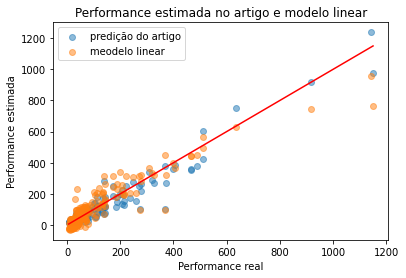

In [5]:
# Comparando o real com o estimado (em caso ideal, identidade y=x)
plt.plot(df['PRP'], df['PRP'], color='red')
plt.scatter(df['PRP'], df['ERP'], alpha=.5, label='predição do artigo')
plt.scatter(df['PRP'], df['lm_pred'], alpha=.5, label='meodelo linear')
plt.title('Performance estimada no artigo e modelo linear')
plt.xlabel('Performance real')
plt.ylabel('Performance estimada')
plt.legend()
plt.show()

In [6]:
# Usando métricas para avaliar ambos modelos
print('Modelo do artigo:')
print(f"MSE: {sklearn.metrics.mean_squared_error(df['PRP'], df['ERP'])}")
print(f"R2: {sklearn.metrics.r2_score(df['PRP'], df['ERP'])}")
print('Regressão Linear:')
print(f"MSE: {sklearn.metrics.mean_squared_error(df['PRP'], df['lm_pred'])}")
print(f"R2: {sklearn.metrics.r2_score(df['PRP'], df['lm_pred'])}")

Modelo do artigo:
MSE: 1737.3349282296651
R2: 0.9325117107972016
Regressão Linear:
MSE: 3478.0866756153564
R2: 0.8648906922768672


A regressão linear, embora bem razoavel para o problema, ainda teve menor desempenho que o modelo do artigo. Vamos tentar melhora-la. Em primeira abordagem, usarei o teste Goldfeldt-Quant para verificar se a variância dos dados apresenta correlação monótona com minhas features, o que prejudicaria a regressão (heterocedasticidade). Na função abaixo, podemos observar a f-statistic e p-valor resultados do teste, além da ordenação usada.

In [12]:
diagnostic.het_goldfeldquandt(y, X)

(55.023678187774024, 3.5490915488502365e-59, 'increasing')

No caso, como suspeitado, há sim uma correlação entre as features e a variância da variável alvo. O modelo de regressão linear, porém, assume variância constante. Lidando com essa situação, podemos melhorar seu desempenho. Como alternativa, tentarei usar o modelo de regressão linear com pesos. A idéia é associar a cada ponto um peso baseado no inverso da variância do valor fitado, o que normalizará a variância do modelo. Para isso testarei pesos nas diferentes features?

In [52]:
for var in ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']:
    wls_model = sm.WLS(y,X, weights=[1/k if k else 0 for k in X[var]])
    results = wls_model.fit()
    df[f'lm_{var}'] = results.predict(X)

In [53]:
# Usando métricas para avaliar ambos modelos
print('Modelo do artigo:')
print(f"MSE: {sklearn.metrics.mean_squared_error(df['PRP'], df['ERP'])}")
print(f"R2: {sklearn.metrics.r2_score(df['PRP'], df['ERP'])}")

mse, r2 = [], []
for var in ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']:
    mse.append(sklearn.metrics.mean_squared_error(df['PRP'], df[f'lm_{var}']))
    r2.append(sklearn.metrics.r2_score(df['PRP'], df[f'lm_{var}']))

Modelo do artigo:
MSE: 1737.3349282296651
R2: 0.9325117107972016


In [58]:
print(max(r2))
print(min(mse))

0.792579718587723
5339.5708200265535


Essa abordagem não surtiu muito efeito, sendo que os parametros do modelo ficaram inferiores à regressão padrão. Vamos explorar uma outra possibilidade. Vamos analisar a correlação entre as features.

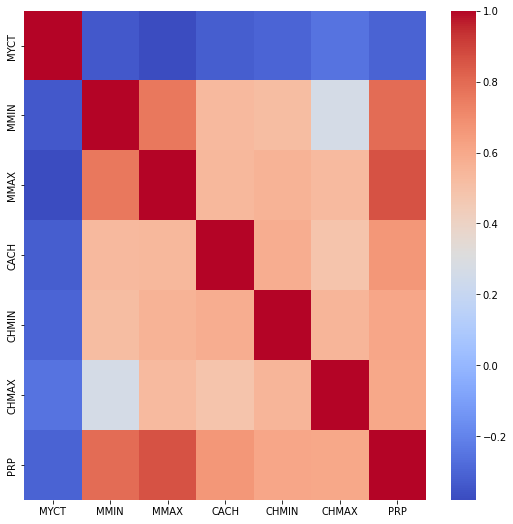

In [96]:
corr = df[['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX','PRP']].corr()
plt.figure(figsize = (9, 9))
sns.heatmap(corr, cmap = 'coolwarm')
plt.show()

MMIN e MMAX são claramente muito correlacionadas. Alem disso, MMAX têm o maior impacto na performance que queremos prever. Vamos olhar mais essa relação:

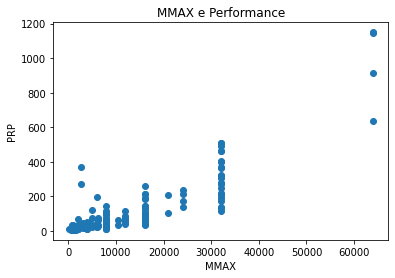

In [100]:
plt.scatter(df['MMAX'], df['PRP'])
plt.title('MMAX e Performance')
plt.xlabel('MMAX')
plt.ylabel('PRP')
plt.show()

Sera valido tentar prever a performace apenas com essa feature

In [109]:
reg = LinearRegression().fit(df[['MMAX']], df['PRP'])
df['mmax_pred'] = reg.predict(df[['MMAX']])
print(f"Score: {reg.score(df[['MMAX']], df['PRP'])}")
print(f'Coeficientes: {reg.coef_}')
print(f'Intercepto: {reg.intercept_}')

Score: 0.744776118671232
Coeficientes: [0.01183617]
Intercepto: -33.99924034304276


In [110]:
print(f"MSE: {sklearn.metrics.mean_squared_error(df['PRP'], df['mmax_pred'])}")
print(f"R2: {sklearn.metrics.r2_score(df['PRP'], df['mmax_pred'])}")

MSE: 6570.167488145871
R2: 0.744776118671232


Realmente, temos um modelo um pouco pior, mas com grande capacidade preditiva, que só confirma a grande representatividade dessa variável. Apliquemos agora PCA mais efetivamente para decidir as variáveis mais relevantes.

In [120]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
X2 = pca.transform(X)

[9.60283667e-01 3.93281442e-02 3.77860090e-04]
[174601.19757958  35334.51821049   3463.48219169]


In [121]:
reg = LinearRegression().fit(X2, y)
df['pca_pred'] = reg.predict(X2)
print(f"Score: {reg.score(X2, y)}")
print(f'Coeficientes: {reg.coef_}')
print(f'Intercepto: {reg.intercept_}')

Score: 0.7927394489374597
Coeficientes: [0.01160048 0.01113437 0.0255988 ]
Intercepto: 105.622009569378


In [122]:
print(f"MSE: {sklearn.metrics.mean_squared_error(df['PRP'], df['pca_pred'])}")
print(f"R2: {sklearn.metrics.r2_score(df['PRP'], df['pca_pred'])}")

MSE: 5335.4589197402365
R2: 0.7927394489374597


Com 3 das 6 componentes principais conseguimos um modelo quase tão bom quanto o inicial, visto que a relevancia das variáveis é geterogeneamente distribuida. Vamos partir para outra abordagem, Support Vector Machines.

In [126]:
clf = sklearn.svm.SVC().fit(X,y)
df['svc_pred'] = clf.predict(X)
print(f"MSE: {sklearn.metrics.mean_squared_error(df['PRP'], df['svc_pred'])}")
print(f"R2: {sklearn.metrics.r2_score(df['PRP'], df['svc_pred'])}")

MSE: 3332.248803827751
R2: 0.8705558914897511


Legal! Com um simples classificador SVC conseguimos melhorar o resultado da regressão linear. Vamos tentar ainda alguns ajustes, variando o kernel, para além do linear, e averiguando os resultados:

In [ ]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    clf = sklearn.svm.SVC(kernel=kernel).fit(X,y)
    df[f'svc_{kernel}_pred'] = clf.predict(X)
    print(f"MSE: {sklearn.metrics.mean_squared_error(df['PRP'], df[f'svc_{kernel}_pred'])}")
    print(f"R2: {sklearn.metrics.r2_score(df['PRP'], df[f'svc_{kernel}_pred'])}")